# 02. Parameter estimation

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator, workers
from estim8.error_models import LinearErrorModel
import pandas as pd
from estim8.objective import objective_function_wrapper, global_objective
from functools import partial
import hopsy
import arviz as az
import numpy as np
import pickle

In [ ]:

from estim8.datatypes import Simulation
from estim8.models import Estim8Model


class MockModel(Estim8Model):
    def __init__(self, default_parameters={}, r_tol=0.0001):
        super().__init__(default_parameters, r_tol)

    def retrieve_variables(self):
        parameters = {"slope": np.exp(1), "offset": 0}
        observables = ["y"]

    def simulate(
        self,
        t0: float,
        t_end: float,
        stepsize: float,
        parameters: dict={},
        observe: list = None,
        replicate_ID: str = None,
    ):
        params = parameters.copy()
        params.update(parameters)

        t = t0 + np.arange(0, t_end) * stepsize
        y = np.power(params["base"], t) + params["offset"]
        return Simulation({"time": t, "y": y})


In [15]:
m = MockModel()

sim = m.simulate(0, 10, 1)

In [33]:
noisy_data = np.random.normal(loc=sim["y"].values, scale=sim["y"].values * 0.02)
data = datatypes.Experiment(
        measurements=[
            datatypes.Measurement(name="y", timepoints=sim["y"].timepoints, values=noisy_data)
        ]
    )

bounds = {"offset": [-2, 2], "base": [0, 5]}
t = [0, 10, 1]


In [34]:
estimator = Estimator(
        model=m, data=data, bounds=bounds, t=t
    )

In [35]:
rs, info = estimator.estimate(method="de", n_jobs=1, max_iter=100, optimizer_kwargs={"disp": True})

differential_evolution step 1: f(x)= 132461.96535680126
differential_evolution step 2: f(x)= 40573.844999408975
differential_evolution step 3: f(x)= 40573.844999408975
differential_evolution step 4: f(x)= 19259.720720952253
differential_evolution step 5: f(x)= 13652.533536139454
differential_evolution step 6: f(x)= 11106.334743179548
differential_evolution step 7: f(x)= 10290.561215771235
differential_evolution step 8: f(x)= 10290.561215771235
differential_evolution step 9: f(x)= 8752.539230885372
differential_evolution step 10: f(x)= 8752.539230885372
differential_evolution step 11: f(x)= 8752.539230885372
differential_evolution step 12: f(x)= 8750.928702332527
differential_evolution step 13: f(x)= 8742.195830460036
differential_evolution step 14: f(x)= 8742.195830460036
differential_evolution step 15: f(x)= 8728.486512631769
differential_evolution step 16: f(x)= 8728.486512631769
differential_evolution step 17: f(x)= 8728.486512631769
Polishing solution with 'L-BFGS-B'


In [36]:
rs

{'offset': 0.16365942264115452, 'base': 2.715049020801124}

In [37]:
m.parameters

{'base': 2.718281828459045, 'offset': 0}

In [32]:
noisy_data

array([9.77112566e-01, 2.68942013e+00, 7.27122525e+00, 1.98329186e+01,
       5.26405855e+01, 1.45816884e+02, 4.22229571e+02, 1.08659680e+03,
       2.95136210e+03, 8.05270548e+03])

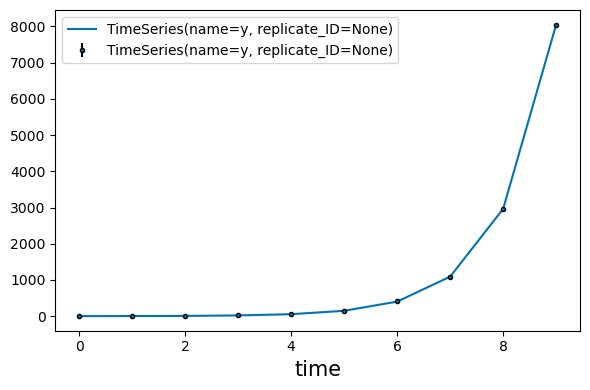

In [24]:
_ = visualization.plot_estimates(rs, estimator=estimator)

In [2]:
# load and init model
SimpleBatchModel = FmuModel(path=r'SimpleBatch.fmu')
# simulate with default parameters
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=0.001)

In [3]:
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0)

data.head()

,X,S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN


In [4]:
# create an Experiment object
experiment = datatypes.Experiment(data, error_model=LinearErrorModel(slope=0.05, offset=0.01) ) 

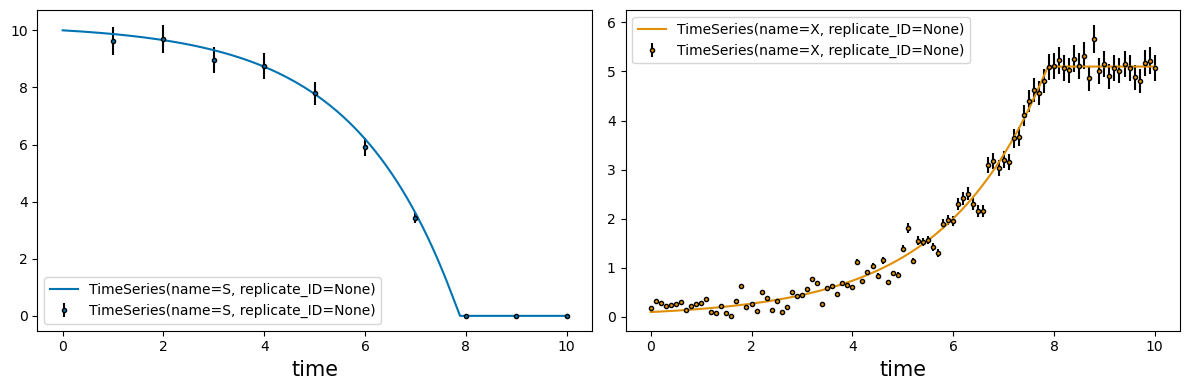

In [5]:
# compare simulation to data
_ = visualization.plot_simulation(simulation=simulation, experiment=experiment, observe=['S', 'X'])

In [6]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

## The `Estimator` class

The `Estimator` class manages the processes of model fitting.

In [7]:
# Instantiating an Estimator object
estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,        # anknowns and bounds
    data=experiment,      # experimental data
    t=[0, 10, 0.1],        # the timeframe for simulation,
    metric = 'negLL'         # default Sum of squared residuals
)

In [ ]:
from typing import Any


class ProblemModel(object):

    def __init__(self, objective) -> None:
        objective = objective

    def log_density(self, theta):
        print(theta)
        return - objective(theta)[0]
    
    def __reduce__(self) -> str | tuple[Any, ...]:
        print("reducing")
        return super().__reduce__()
    
    def __getstate__(self):
        print("getting state")
        return __dict__
    
    def setstate(self, state):
        print("setting state")
        __dict__.update(state)


In [9]:
A = np.row_stack((np.identity(3), -np.identity(3)))

b = [val[1] for val in estimator.bounds.values()] + [-val[0] for val in estimator.bounds.values()]


In [10]:
func = partial(global_objective, local_objective = workers.Worker(estimator))
objective = partial(objective_function_wrapper, objective=pickle.dumps(func))

In [11]:
problem = hopsy.Problem(A, b, ProblemModel(objective))

In [12]:
mcs, rngs = hopsy.setup(problem=problem, random_seed=42, n_chains=4, proposal=hopsy.GaussianCoordinateHitAndRunProposal)

[0.1  0.15 0.15]
[0.1  0.15 0.15]
[0.1  0.15 0.15]
[0.1  0.15 0.15]


In [13]:
statistics, samples = hopsy.sample(mcs, rngs, 10, n_procs=1,  record_meta=["acceptance_rate", "state_log_density"])

[0.1        0.15934591 0.15      ]
[0.1        0.15934591 0.45538491]
[0.11487899 0.15934591 0.15      ]
[0.11487899 0.78394761 0.15      ]
[0.11487899 0.78394761 0.44691508]
[0.1293748  0.78394761 0.15      ]
[0.1293748  0.53898463 0.15      ]
[0.1293748  0.78394761 0.21746152]
[0.13443541 0.78394761 0.15      ]
[0.13443541 0.29272605 0.15      ]
[0.1        0.20972604 0.15      ]
[0.1        0.20972604 0.50227893]
[0.12469919 0.20972604 0.15      ]
[0.12469919 0.66201572 0.15      ]
[0.12469919 0.66201572 0.82334814]
[0.07858527 0.66201572 0.15      ]
[0.12469919 0.44078454 0.15      ]
[0.12469919 0.66201572 0.71746769]
[0.14833211 0.66201572 0.15      ]
[0.14833211 0.40255801 0.15      ]
[0.1        0.25659977 0.15      ]
[0.1        0.25659977 0.91380028]
[0.07014762 0.25659977 0.15      ]
[0.1        0.58405321 0.15      ]
[0.1        0.58405321 0.89628713]
[0.07175204 0.58405321 0.15      ]
[0.1        0.72334952 0.15      ]
[0.1        0.72334952 0.15444046]
[0.05949562 0.723349

In [14]:
l = pickle.dumps(problem)
p = pickle.loads(l)

reducing


In [15]:
p.model.objective([0.1,   0.15934591, 0.15      ])

[10511.878226679079]

In [ ]:
statistics, samples = hopsy.sample(mcs, rngs, 10, n_procs=4,  record_meta=["acceptance_rate", "state_log_density"])


reducing
reducing
reducing
reducing
